In [227]:
import pandas as pd
import numpy as np

## 9

In [228]:
likes = pd.read_csv('likes.csv')
likes[:5]

,user_id,post_id,timestamp
0,128381,4704,1654030804
1,146885,1399,1654030816
2,50948,2315,1654030828
3,14661,673,1654030831
4,37703,1588,1654030833


In [229]:

views = pd.read_csv('views.csv')
views[:5]

,user_id,exp_group,recommendations,timestamp
0,128381,control,[3644 4529 4704 5294 4808],1654030803
1,146885,test,[1399 1076 797 7015 5942],1654030811
2,50948,test,[2315 3037 1861 6567 4093],1654030825
3,37703,test,[2842 1949 162 1588 6794],1654030826
4,14661,test,[2395 5881 5648 3417 673],1654030829


In [230]:
df = likes[['user_id','post_id']].set_index('user_id')\
    .join(
        views[['user_id','exp_group']].set_index('user_id'),
        how='outer'
    ).reset_index()

In [231]:
df.groupby(['user_id', 'exp_group']).size().unstack().notna().sum()

exp_group
control    32354
test       32663
dtype: int64

In [232]:
gr = df.groupby('user_id')['exp_group'].agg(['nunique'])

In [233]:
duplicates = gr[gr['nunique']!=1]
duplicates

,nunique
user_id,
25623,2
55788,2
142283,2
148670,2


In [234]:
df.shape

(1017173, 3)

In [235]:
df = df[~df['user_id'].isin(duplicates.index)]
df.shape

(1016889, 3)

In [236]:
df.groupby('exp_group').count()

,user_id,post_id
exp_group,,
control,497521,492115
test,519368,514243


In [237]:
from scipy import stats

stats.binom_test(497521	, n=1016889, p=0.5) # probability to not getting inside the condifence interval

c:\Users\grokh\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_discrete_distns.py:69: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


4.421891889008788e-104

## 10

In [238]:
likes[:5]

,user_id,post_id,timestamp
0,128381,4704,1654030804
1,146885,1399,1654030816
2,50948,2315,1654030828
3,14661,673,1654030831
4,37703,1588,1654030833


<AxesSubplot:>

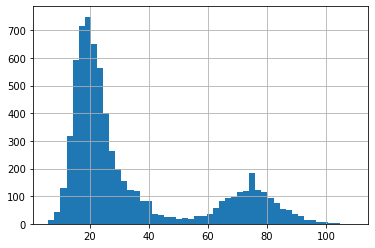

In [239]:
likes.groupby('post_id').size().sort_values(ascending=False).hist(bins=50)

In [240]:
likes.shape

(230176, 3)

In [241]:
print(views.shape)
views[:5]

(193295, 4)


,user_id,exp_group,recommendations,timestamp
0,128381,control,[3644 4529 4704 5294 4808],1654030803
1,146885,test,[1399 1076 797 7015 5942],1654030811
2,50948,test,[2315 3037 1861 6567 4093],1654030825
3,37703,test,[2842 1949 162 1588 6794],1654030826
4,14661,test,[2395 5881 5648 3417 673],1654030829


In [242]:
df = views.groupby('user_id').first().drop('timestamp', axis=1)\
    .join(
        likes.groupby('user_id').count(), 
        how='left'
    )

In [243]:
df.post_id.notna().sum() / df.post_id.size

0.8947595096365343

## 11

In [244]:
df.dropna().groupby('exp_group').size() # number of likes per group

exp_group
control    28835
test       29336
dtype: int64

<AxesSubplot:>

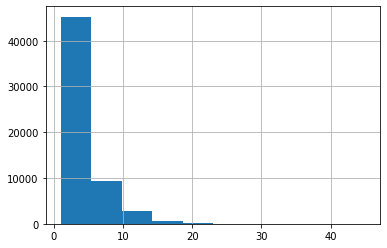

In [245]:
df.post_id.hist()

In [246]:
df.fillna(0, inplace=True)

In [247]:
df[df.post_id!=0].post_id.size / df.post_id.size

0.8947595096365343

In [248]:
df.post_id.mean() # num of likes per user

3.5404611385415223

## 12

In [249]:
from scipy.stats import mannwhitneyu

mannwhitneyu(
    x=df[df.exp_group=='test'].post_id,
    y=df[df.exp_group=='control'].post_id,
    alternative = 'greater'
) # Nlikesl hypothesis "test metric is not greater than control metric" is rejected. Hence, we have a statistically significant enhancement

MannwhitneyuResult(statistic=538250082.5, pvalue=1.4155557027249649e-05)

In [250]:
df['nonzero'] = (df.post_id!=0).map({True:1, False:0})

In [251]:
mannwhitneyu(
    x=df[df.exp_group=='test'].nonzero,
    y=df[df.exp_group=='control'].nonzero,
    alternative = 'greater'
) # Nlikesl hypothesis "test metric is not greater than control metric" is rejected. Hence, we have a statistically significant enhancement

MannwhitneyuResult(statistic=531944264.0, pvalue=0.0022090448695365893)

## 13

In [252]:
views = views.rename(columns={'timestamp':'views_ts'})
likes = likes.rename(columns={'timestamp':'likes_ts'})
views.shape

(193295, 4)

In [253]:
recs = (
    views.recommendations
    .str.replace('\D', ' ', regex=True)
    .str.split().explode()
    .astype(int).to_frame()
).join(
    views.drop('recommendations', axis=1)
).rename(
    columns={'recommendations':'post_id'}
).groupby(
    ['user_id', 'post_id']
).first().join(
    likes.groupby(['user_id','post_id']).first(),
    how = 'outer'
)

recs

exp_group    views_ts      likes_ts
user_id post_id                                    
200     1563         test  1655009047           NaN
        4127         test  1655009047           NaN
        5135         test  1655009047           NaN
        5510         test  1655009047           NaN
        5559         test  1655009047  1.655009e+09
...                   ...         ...           ...
168552  3643      control  1654885693           NaN
        3769      control  1654516294           NaN
        4130      control  1654516294           NaN
        4558      control  1654516294           NaN
        6918      control  1654516294           NaN

[964715 rows x 3 columns]

In [254]:
recs['relevant'] = np.where(
    (recs.likes_ts-recs.views_ts) > 3600,
    0, 1
)

recs['relevant'] = np.where(
    recs.likes_ts < recs.views_ts,
    0, recs['relevant']
)
print(recs.shape)
recs = recs[recs.relevant==1]
print(recs.shape)

(964715, 4)
(964422, 4)


In [255]:
recs = (recs.reset_index()
    .groupby(['user_id', 'views_ts'])
    .count()
)
recs['hitrate'] = np.where(
    recs.likes_ts != 0,
    1, 0
)
recs = recs[['likes_ts', 'relevant', 'hitrate']]
recs

likes_ts  relevant  hitrate
user_id views_ts                               
200     1655009047         1         5        1
201     1654043283         0         5        0
        1654173790         0         5        0
        1654444704         1         5        1
        1654517459         0         5        0
...                      ...       ...      ...
168545  1654295281         1         5        1
        1654412184         1         5        1
        1654887207         1         5        1
168552  1654516294         0         5        0
        1654885693         0         5        0

[193295 rows x 3 columns]

In [256]:
recs.hitrate.sum() / recs.hitrate.size

0.7125274838976694

## 14

In [257]:
import hashlib

bucket = recs.index.get_level_values(0).to_series().apply(
    lambda x: int(hashlib.md5((str(x) + 'my_salt2').encode()).hexdigest(), 16) % 100
)

recs['bucket'] = bucket.values
recs[:5]

likes_ts  relevant  hitrate  bucket
user_id views_ts                                       
200     1655009047         1         5        1      75
201     1654043283         0         5        0      55
        1654173790         0         5        0      55
        1654444704         1         5        1      55
        1654517459         0         5        0      55

In [258]:
recs = recs.reset_index().set_index('user_id')

In [259]:
s = views.set_index('user_id')['exp_group'].sort_index()

In [260]:
if all(recs.index == s.index):
    recs = pd.concat([recs,s], axis=1)
else:
    raise ValueError('duck you')

In [262]:
recs

,views_ts,likes_ts,relevant,hitrate,bucket,exp_group
user_id,,,,,,
200,1655009047,1,5,1,75,test
201,1654043283,0,5,0,55,test
201,1654173790,0,5,0,55,test
201,1654444704,1,5,1,55,test
201,1654517459,0,5,0,55,test
...,...,...,...,...,...,...
168545,1654295281,1,5,1,83,test
168545,1654412184,1,5,1,83,test
168545,1654887207,1,5,1,83,test


In [263]:
new_recs = recs.groupby(['exp_group', 'bucket']).mean()[['hitrate']].reset_index()
new_recs

,exp_group,bucket,hitrate
0,control,0,0.700000
1,control,1,0.732124
2,control,2,0.691309
3,control,3,0.701020
4,control,4,0.708520
...,...,...,...
195,test,95,0.707091
196,test,96,0.711663
197,test,97,0.718519
198,test,98,0.681043


In [270]:
new_recs[new_recs.exp_group=='test'].hitrate.mean()

0.7191235421376634

In [271]:
new_recs[new_recs.exp_group=='control'].hitrate.mean()

0.7058801016829941

In [268]:
mannwhitneyu(
    x=new_recs[new_recs.exp_group=='test'].hitrate,
    y=new_recs[new_recs.exp_group=='control'].hitrate,
    alternative = 'greater'
) # Null hypothesis "test metric is not greater than control metric" is rejected. Hence, we have a statistically significant enhancement

MannwhitneyuResult(statistic=7082.5, pvalue=1.8175225126095138e-07)

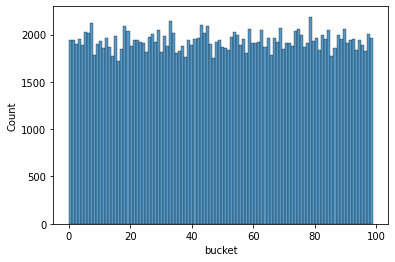

In [223]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(recs.bucket, bins=100)
plt.show()